In [9]:
import tensorflow as tf 
from tensorflow.keras import models,layers 
import matplotlib.pyplot as plt 

In [11]:
ImageSize =256 
BatchSize =32 

In [13]:
dataset = tf.keras.preprocessing .image_dataset_from_directory(
    "PlantVillage" ,
    shuffle=True,
    image_size=(ImageSize,ImageSize) ,
    batch_size = BatchSize
)
    


Found 2152 files belonging to 3 classes.


In [15]:
class_names =dataset.class_names
class_names 

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [17]:
len(dataset)

68

In [19]:
68*32

2176

In [21]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
for img_batch , label_batch in dataset.take(1):
    print (label_batch)
    print (label_batch.shape)
    print (img_batch[0])
    

tf.Tensor([0 0 1 0 0 1 1 2 1 0 0 1 0 1 1 1 1 0 1 1 1 0 2 0 1 2 1 0 0 1 1 0], shape=(32,), dtype=int32)
(32,)
tf.Tensor(
[[[189. 193. 204.]
  [201. 205. 216.]
  [205. 209. 220.]
  ...
  [141. 143. 156.]
  [157. 159. 172.]
  [137. 139. 152.]]

 [[199. 203. 214.]
  [198. 202. 213.]
  [188. 192. 203.]
  ...
  [127. 129. 142.]
  [142. 144. 157.]
  [138. 140. 153.]]

 [[193. 197. 208.]
  [188. 192. 203.]
  [184. 188. 199.]
  ...
  [122. 124. 137.]
  [133. 135. 148.]
  [137. 139. 152.]]

 ...

 [[152. 154. 166.]
  [149. 151. 163.]
  [146. 148. 160.]
  ...
  [ 69.  71.  83.]
  [102. 104. 116.]
  [159. 161. 173.]]

 [[150. 152. 164.]
  [146. 148. 160.]
  [144. 146. 158.]
  ...
  [133. 135. 148.]
  [129. 131. 144.]
  [ 93.  95. 108.]]

 [[158. 160. 172.]
  [154. 156. 168.]
  [151. 153. 165.]
  ...
  [103. 105. 118.]
  [105. 107. 120.]
  [107. 109. 122.]]], shape=(256, 256, 3), dtype=float32)


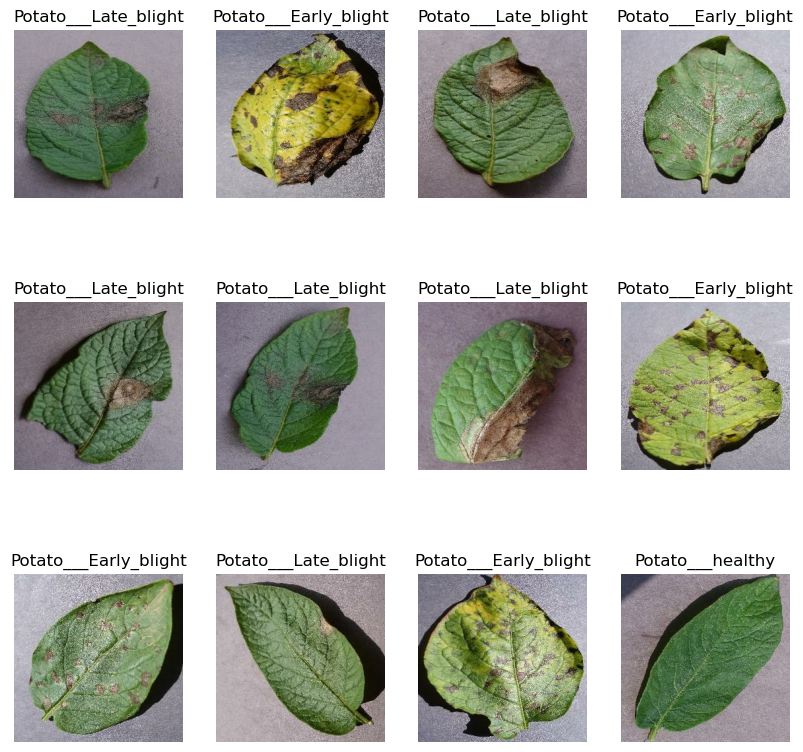

In [24]:
plt.figure(figsize=(10,10))
for img_batch , label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.axis('off')
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
    


### 80% ==> training 
### 20% ==> 10% validation , 10% test

In [27]:
train_size = 0.8
len(dataset)*train_size 

54.400000000000006

In [28]:
train_Ds = dataset.take(54)
len(train_Ds)

54

In [29]:
test = dataset.skip(54)
len(test)

14

In [30]:
val_Ds = test.take(7)
test_Ds = test.skip(7)

In [31]:
def get_dataset_partitions_tf(ds , train_split= 0.8 , val_split = 0.1 , test_split= 0.1 , shuffle=True , shuffle_size = 1000 ):
    ds_size=len(ds)
    if shuffle :
        ds=ds.shuffle(shuffle_size, seed =12)
        # what does seed do???????
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_Ds = ds.take(train_size)
    
    val_Ds = ds.skip(train_size).take(val_size) 
    test_Ds = ds.skip(train_size).skip(val_size)

    return train_Ds , val_Ds , test_Ds 



In [32]:
train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [33]:
len(train_ds)

54

In [34]:
len(test_ds)

8

In [35]:
len(val_ds)

6

In [36]:
#cache stores the data in cache for the next epoch 
# prefetch--> CPU fetches the next batch while GPU is trining the current batch (but you dont have a GPU :)  )
# buffer_size lets it decide how many batch to load while GPU is training

In [37]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [38]:
# train_ds = train_ds.map(lambda x: x/255)
resize_and_rescale= tf.keras.Sequential([
    layers.Resizing(ImageSize, ImageSize),
    layers.Rescaling(1.0/255)
])

In [39]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical") , 
    layers.RandomRotation(0.2) 
])

# model

In [57]:
input_shape = (BatchSize , ImageSize , ImageSize , 3)
model = models.Sequential([
    resize_and_rescale , 
    data_augmentation ,
    layers.Conv2D(32 , (3,3) ,activation='relu' , input_shape = input_shape),
    layers.MaxPooling2D((2,2)),              
    layers.Conv2D(64 , (3,3) ,activation='relu' ),
    layers.MaxPooling2D((2,2)),              
    layers.Conv2D(64 , (3,3) ,activation='relu' ),
    layers.MaxPooling2D((2,2)),              
    layers.Conv2D(64 , (3,3) ,activation='relu' ),
    layers.MaxPooling2D((2,2)),              
    layers.Conv2D(64 , (3,3) ,activation='relu'),
    layers.MaxPooling2D((2,2)),              
    layers.Conv2D(64 , (3,3) ,activation='relu'),
    layers.MaxPooling2D((2,2)),  
    layers.Flatten() ,
    layers.Dense(64 , activation= 'relu'),
    layers.Dense(3 , activation= 'softmax'),
                 
                  
])
model.build(input_shape=input_shape)

C:\Users\SSS\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model.compile(
    optimizer = 'adam' ,
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics= ['accuracy']
    
)

In [ ]:
history = model.fit(
    train_ds , 
    epochs=30 ,
    batch_size = BatchSize ,
    verbose =1 , 
    validation_data = val_ds ,
    
    
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.4981 - loss: 0.9138 - val_accuracy: 0.6458 - val_loss: 0.7191
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7246 - loss: 0.6656 - val_accuracy: 0.8438 - val_loss: 0.3543
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8642 - loss: 0.3588 - val_accuracy: 0.8906 - val_loss: 0.2729
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8830 - loss: 0.3023 - val_accuracy: 0.9271 - val_loss: 0.1750
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9116 - loss: 0.2085 - val_accuracy: 0.9062 - val_loss: 0.2002
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9306 - loss: 0.1925 - val_accuracy: 0.9010 - val_loss: 0.2361
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9348 - loss: 0.1559 - val_accuracy: 0.9062 - val_loss: 0.2560
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9268 - loss: 0.1742 - val_accuracy: 0.9792 - val_los

In [7]:
score  = model.evaluate(test_ds )

NameError: name 'model' is not defined

In [152]:
score

[0.30923137068748474, 0.90625]

In [158]:
history

In [160]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [162]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [63]:
for a in history.history:
    print(a['accuracy'])
    print(history.history['val_accoracy'])

NameError: name 'history' is not defined

In [168]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



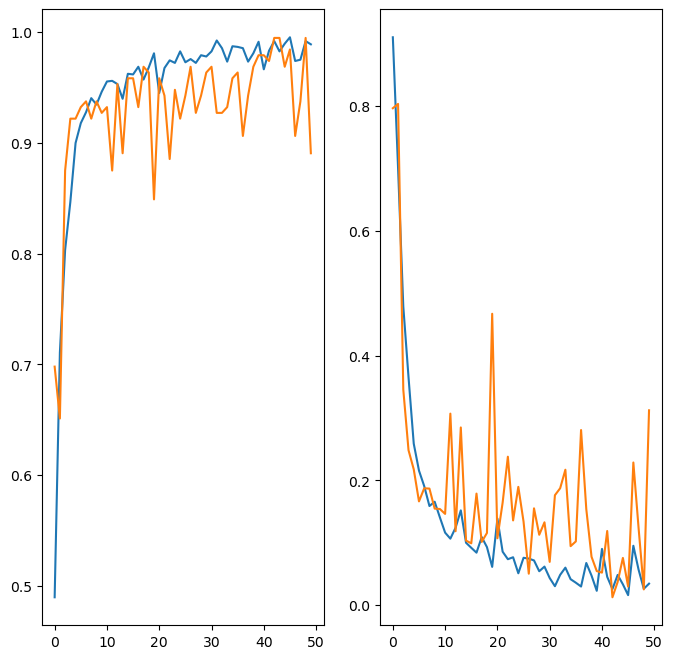

In [184]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50) , acc)

plt.plot(range(50) , val_acc)
plt.subplot(1,2,2)
plt.plot(range(50) , loss)
plt.plot(range(50) , val_loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


NameError: name 'argmax' is not defined

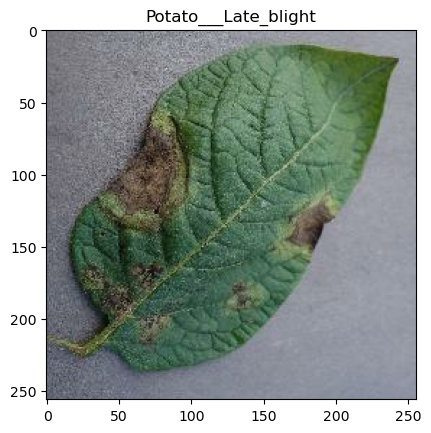

In [204]:
for img , lab in test_ds.take(1):
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.title(class_names[lab[0].numpy()])

    batch_pred = model.predict(img)
    print(argmax(batch_pred[0]))

In [200]:
batch_pred[0]

array([2.9354844e-05, 9.9997067e-01, 3.2562875e-10], dtype=float32)